<a href="https://colab.research.google.com/github/joel-soffo/joel-soffo/blob/main/QMC_HESTON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3)Reprendre la comparaison en se basant sur du quasi-Monte Carlo.

Il existe deux principales méthodes de construction des méthodes quasi-Monte Carlo :

-les règles de treillis(Lattice) et

-les réseaux numériques(digital Nets)



Pour notre travail, nous allons utiliser la séquence Sobol(que nous avons télécharger en ligne car il existe des sequence déjà générées par les ajuteurs **FY Kuo & D. Nuyens**(ref:reference: FY Kuo & D. Nuyens. Application des méthodes quasi-Monte Carlo aux EDP elliptiques à coefficients de diffusion aléatoires - une enquête d'analyse et de mise en œuvre, Foundations of Computational Mathematics , 16(6):1631-1696, 2016) . c'est un exemple de séquence quasi-aléatoire à faible écart. La séquence de Sobol est toujours définie en base 2, où b = 2. 

Ainsi nous allons travailler donc avec le système base 2 dans cette partie.

Pour genérer ainsi les réseaux numériques, nous utiliserons quatre fonctions a savoir:

-changeToBin(n,k) pour quitter de la base 10 à la base 2

-generatePointSet(k), qui definit les point set avec $ n=b^k $ points

-generatingMatrix(generatingVector) et 

-digitalSeq(t)  qui  sera utilisée pour calculer la i-ème coordonnée du j-ème point de la séquence numérique



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import *
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import math
import random

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Pour l'implementation de cette methode, nous allons utiliser la transformation de Box et Muller , pour générer notre mouvement brownien.

Si on veut utiliser une simulation basé sur la loi uniforme, on a besoin de faire une une autre etape; puisque le princing est base sur la loi normale,on a besoin de faire un changement de la loi uniforme en loi normale, en utilisant un simple algorithme appélé la transformation de Box-Muller; on a donc le code suivant:


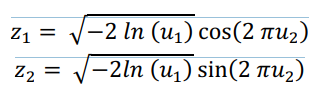

In [2]:
def zscore(sobol_sqeuence):
 for i in range(len(sobol_sqeuence[0])):
  for j in range(i+1,len(sobol_sqeuence[0])):
   if i != j:
    z1=np.sqrt(-2*np.log(sobol_sqeuence[:,i]))*np.cos(2*math.pi*sobol_sqeuence[:,j])
    z2=np.sqrt(-2*np.log(sobol_sqeuence[:,i])*np.sin(2*math.pi*sobol_sqeuence[:,j]))
 #   if i==0 and j==1: 
    z=np.column_stack((z1,z2))
   else:
     z=np.column_stack((z,z1))
     z=np.column_stack((z,z2))
 for i in range(-1,-len(sobol_sqeuence[0]),-1):
  for j in range(i-1,-len(sobol_sqeuence[0]),-1):
   if i != j:
    z1=np.sqrt(-2*np.log(sobol_sqeuence[:,i]))*np.cos(2*math.pi*sobol_sqeuence[:,j])
    z2=np.sqrt(-2*np.log(sobol_sqeuence[:,i]))*np.sin(2*math.pi*sobol_sqeuence[:,j])
    z=np.column_stack((z,z1))
    z=np.column_stack((z,z2))
 return (z1,z2,z)

Dans la suite, nous décrivons toutes les fonctions que nous avons mentionnées au début de cette section qui vont nous permettre de generer nos reseaux numeriques

In [3]:
# elle permet de quitter de la base 10   à la base 2

def changeToBin(n,m):
 set = []
 while (n>=1):
  set.append(n%2)
  n=int(n/2)
 while(len(set)!=m):
  set.append(0)
 return set

La fonction suivante nous permet de definir l'ensemble des point set

In [4]:
def generatePointSet(m):
 p = 2**m # le nombre de points dans les reseaux numeriques(digital Nets)
 p_set = []
 for i in range(p):
  p_set.append(changeToBin(i,m))
 return np.array(p_set)

 Nous avions téléchargé un paquet de matrices de génération en ligne, qui contient différentes rangées de générateur de matrices. Chaque ligne de ce paquet est unique et en base 10. Dans la fonction generatingMatrix(generatingVector), nous utilisons les différentes rangées du paquet pour générer différentes matrices de génération pour le calcul. Dans cette fonction, nous devons changer la base 10 en base 2. 
Après cela, nous devons effectuer une transposition de matrice pour obtenir la matrice triangulaire supérieure.

In [5]:
def generatingMatrix(generatingVector):
 m=len(generatingVector)
 GeneratingMatrix=[]
 for i in generatingVector:
  GeneratingMatrix.append(changeToBin(i,m))  # ici on fait appel à la fonction changeToBin
 return np.array(GeneratingMatrix).transpose()

Nous passons maintenant à la génération des séquences numeriques.
Les séquences numériques de base 2 sont générées par deux variables différentes. La première est s, qui représente le nombre de matrices génératrices à utiliser, comptées depuis le début. La seconde est m, qui est utilisée pour calculer le nombre de points nécessaires pour tracer le graphique.

In [6]:
def digitalSeq(t):
 u_ij=np.array([])
 for i in range(len(t)):
  u=0
  k=0
  for j in t[i]:
   u=u+j*2**(-k-1)
   k=k+1
  u_ij=np.append(u_ij,u)
 return np.array(u_ij)

In [7]:
# cette version prend compte la système base 2 
def digitalseq_b2(s,k): 
 point=generatePointSet(k)               # ici on fait appel a la fonction generatePointSet
 C_table=np.loadtxt('/sobol_Cs.col.txt') # ici on a utilisé le paquet  sobol qui est disponible en ligne 
 Cs=C_table.transpose()[0:k].transpose()
 AlldigitalSeq=[]
 for i in range(s):
  G=generatingMatrix(Cs[i])              # on fait appel a la fonction generatingMatrix
  t=np.matmul(G,point.transpose()).transpose()%2
  digi=digitalSeq(t)
  AlldigitalSeq.append(digi)
 return AlldigitalSeq

In [8]:
# exemple de resultat de ce que la fonction précédente fait
y = digitalseq_b2(9,9)
y[6]

array([0.        , 0.5       , 0.75      , 0.25      , 0.625     ,
       0.125     , 0.375     , 0.875     , 0.8125    , 0.3125    ,
       0.0625    , 0.5625    , 0.4375    , 0.9375    , 0.6875    ,
       0.1875    , 0.34375   , 0.84375   , 0.59375   , 0.09375   ,
       0.96875   , 0.46875   , 0.21875   , 0.71875   , 0.53125   ,
       0.03125   , 0.28125   , 0.78125   , 0.15625   , 0.65625   ,
       0.90625   , 0.40625   , 0.578125  , 0.078125  , 0.328125  ,
       0.828125  , 0.203125  , 0.703125  , 0.953125  , 0.453125  ,
       0.265625  , 0.765625  , 0.515625  , 0.015625  , 0.890625  ,
       0.390625  , 0.140625  , 0.640625  , 0.796875  , 0.296875  ,
       0.046875  , 0.546875  , 0.421875  , 0.921875  , 0.671875  ,
       0.171875  , 0.109375  , 0.609375  , 0.859375  , 0.359375  ,
       0.734375  , 0.234375  , 0.484375  , 0.984375  , 0.2421875 ,
       0.7421875 , 0.9921875 , 0.4921875 , 0.6171875 , 0.1171875 ,
       0.3671875 , 0.8671875 , 0.9296875 , 0.4296875 , 0.17968

In [9]:
#Dans la suite, nous considerons les données suivantes 

m=7  # elle servira a calucler le nombre de point dans la reseaux numeriques
s=50 # nombre de matrices génératrices à utiliser,
point=generatePointSet(m) 
C_table=np.loadtxt('/sobol_Cs.col.txt')
Cs=C_table.transpose()[0:m].transpose()
G=[]
demoSqeMatrix=[]
demoSqe=[]
for i in range(s):
 G.append(generatingMatrix(Cs[i]))
 demo=np.matmul(G[i],point.transpose())%2
 demoSqeMatrix.append(demo)
 demoSqe.append(digitalSeq(demo.transpose()))

In [10]:
# On va donc appliquer la methode Monté Carlo standard en utisant juste une distribution uniforme
tu=np.random.uniform(0,1,(128,50))
zz1=zscore(tu)
Z1=zz1[0]
Z2=zz1[1]
Z3=zz1[2]
print(Z3)
Z3[1].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


[[ 0.56222893  0.13421255  1.85531802 ... -0.5732607  -0.12503416
  -0.16948582]
 [-0.19722908         nan -0.71895066 ...  0.06014174 -1.64860114
   0.05753677]
 [-1.15737643         nan -1.06007374 ... -1.27251308  0.44431549
  -0.41872107]
 ...
 [ 0.6607754          nan -0.17327629 ... -1.44497447 -1.3030639
  -1.5799235 ]
 [ 0.02866805         nan -0.43896073 ...  0.41104557 -0.70030572
   0.0990982 ]
 [ 0.14559946  0.34166672  1.7046247  ... -0.22120245 -1.56254736
  -0.17088228]]


(2354,)

In [25]:
steps = 50
T = 10
kappa =2
dt = T/steps
theta = 0.3
v_0 =  0.04
xi = 0.5
r = 0.03
S = 100
Npaths =15
rho = 0.2
v_t_mc= v_0
K=100
size = (Npaths, steps)
Sprices=np.zeros(size)
sigs=np.zeros(size)
C=np.zeros(size)
for t in range(steps):
  tu=np.random.uniform(0,1,size)
  zz1=zscore(tu)
  Z1=zz1[0]
  Z2=zz1[1] 
  v_t_mc = np.abs(v_t_mc + kappa*(theta-v_t_mc)*dt + xi*np.sqrt(v_t_mc)*Z2)
  S_t_mc = S*(np.exp( (r- 0.5*v_t_mc)*dt+ np.sqrt(v_t_mc)*(rho*Z1+np.sqrt(1-rho**2) *Z2)))
  C_0 = math.exp(-r * T) * (np.maximum(np.mean(S_t_mc)-K, 0)) 
  Sprices[:,t] = S_t_mc
  sigs[:,t] = v_t_mc
  C[:,t] =C_0

print( C)
print( Sprices)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


[[1.62891639e+00 5.86662955e+00 2.48854661e+01 1.83099152e+01
  1.04789575e+02 4.34916325e+01 2.81997624e+00 6.08979324e+01
  1.48794854e+01 5.71299985e+01 6.30991931e+01 1.71894885e+01
  0.00000000e+00 4.21964316e+02 6.85350828e+01 1.28562885e+01
  1.33826824e-01 5.28713855e+00 7.12205357e+01 7.16466341e+01
  7.94329045e+00 4.62234049e+01 1.08080200e+02 3.33227899e+01
  1.73010248e+02 2.07773254e+01 2.01283235e+01 8.46481458e+01
  4.80897717e+01 6.17506570e+00 3.82480270e+01 1.40323298e+02
  5.38972680e+01 7.06153148e+00 3.97304807e+01 3.86411897e+01
  2.01594537e+01 1.42731477e+01 3.54019470e+01 3.93414840e+01
  3.92284261e+01 6.61332025e+01 1.61117786e+01 1.42429511e+01
  3.75806827e+01 7.19615730e+01 9.24773718e+01 4.23627403e+01
  2.75973091e+01 4.40968323e+01]
 [1.62891639e+00 5.86662955e+00 2.48854661e+01 1.83099152e+01
  1.04789575e+02 4.34916325e+01 2.81997624e+00 6.08979324e+01
  1.48794854e+01 5.71299985e+01 6.30991931e+01 1.71894885e+01
  0.00000000e+00 4.21964316e+02 6.853

In [78]:
demoSqe1= np.array(demoSqe)
zz2 = zscore(demoSqe1)
zz2

steps = 128
T = 10
kappa =2
dt = T/steps
theta = 0.3
v_0 =  0.04
xi = 0.5
r = 0.03
S = 100
paths =1
rho = 0.2
v_t= v_0
K= 50
v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*zz2[2])
S_t = S*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t)*zz2[2]))
C_0 = math.exp(-r * T) * (np.maximum(np.mean(S_t)-K, 0)) 
print(S_t)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


[[169.18353385          nan  96.75721055 ...  99.91946604  61.32435745
   99.91946604]
 [169.18353385          nan  96.75721055 ...  99.91946604  95.09984872
   99.91946604]
 [ 36.35462157          nan 158.90346929 ...  99.91946604  95.09984872
   99.91946604]
 ...
 [137.92847911 135.78296187  59.45926383 ...  99.91946604  95.09984872
   99.91946604]
 [ 93.39622909 122.32989025 134.53933824 ...  99.91946604  61.32435745
   99.91946604]
 [ 92.0878292           nan 106.40701472 ...  99.91946604  61.32435745
   99.91946604]]


Afin de remerdier aux valeur nan de la trajectoire de S_t , on va remplace toute NaN par le premier numéro de l'occurrence vers la droite, si aucune n'existe, qu'il remplace par le premier numéro de l'apparition de la gauche. Ainsi, la valeur de l'option pourra être obtenue 

In [80]:
import pandas as pd
from pandas import DataFrame
Data = DataFrame()
C_0=np.zeros(50)
for i in range(50):
  Data[i] = S_t[i]

  nansIndx = np.where(np.isnan(Data[i]))[0]
  isanIndx = np.where(~np.isnan(Data[i]))[0]
  for nan in nansIndx:
      replacementCandidates = np.where(isanIndx>nan)[0]
      if replacementCandidates.size != 0:
         replacement = Data[i][isanIndx[replacementCandidates[0]]]
      else:
         replacement = Data[i][isanIndx[np.where(isanIndx<nan)[0][-1]]]
       
      Data[i][nan] = replacement
  C_0[i] = math.exp(-r * T) * (np.maximum(np.mean(Data[i])-K, 0))
C_0_qmc= np.array(C_0)
print(Data)
print(C_0_qmc)

               0           1           2           3           4           5   \
0      169.183534  169.183534   36.354622  132.507820  154.080706  117.733097   
1       96.757211   96.757211  158.903469  137.605837  126.561736  139.896540   
2       96.757211   96.757211  158.903469   66.067031   41.819600   88.141222   
3      100.092238  100.092238  109.063444   71.454759   98.267110   62.552107   
4       99.748319  100.092238   93.960563  190.705222   98.267110   62.552107   
...           ...         ...         ...         ...         ...         ...   
15999  134.485225   61.324357   61.324357   61.324357  134.485225  134.485225   
16000   95.099849   61.324357   61.324357   61.324357   95.099849   95.099849   
16001   99.919466   99.919466   99.919466   99.919466   99.919466   99.919466   
16002   61.324357   95.099849   95.099849   95.099849   61.324357   61.324357   
16003   99.919466   99.919466   99.919466   99.919466   99.919466   99.919466   

               6           

No handles with labels found to put in legend.


[]

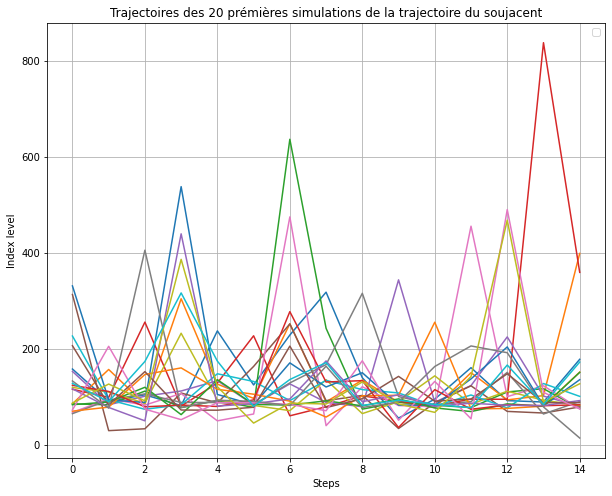

In [13]:
from IPython.core.pylabtools import figsize
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(Sprices[:,:20])
plt.grid(True)
plt.xlabel('Steps')
plt.ylabel('Index level')
plt.title('Trajectoires des 20 prémières simulations de la trajectoire du soujacent')
plt.legend()
plt.plot()

No handles with labels found to put in legend.


[]

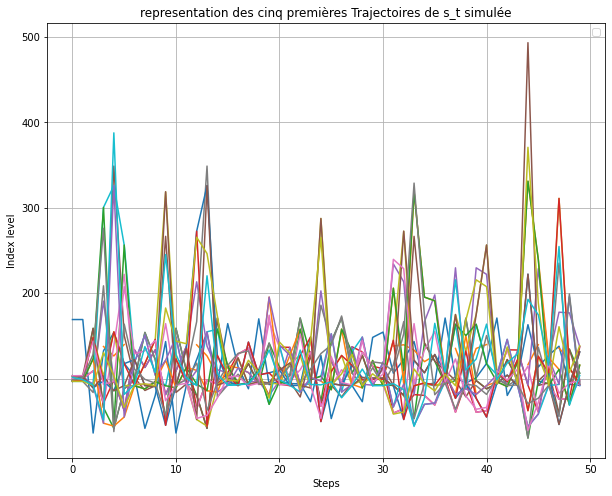

In [14]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(S_t[:,:20])
plt.grid(True)
plt.xlabel('Steps')
plt.ylabel('Index level')
plt.title('representation des cinq premières Trajectoires de s_t simulée')
plt.legend()
plt.plot()

Text(0.5, 1.0, 'Histogramme de la trajectoire du sous jacent basé sur MC')

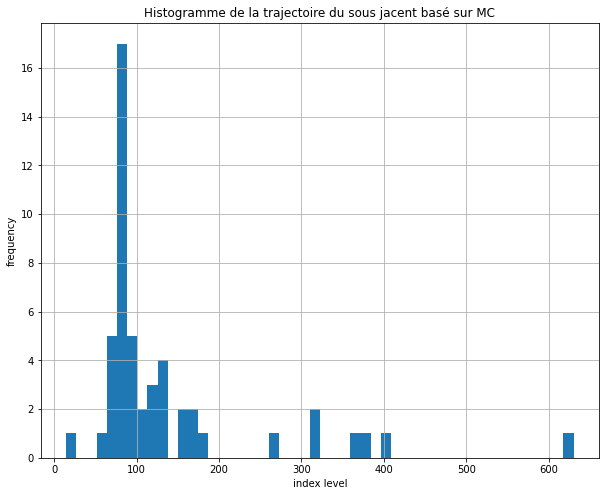

In [15]:
#Reprsentation  des histogrames
plt.hist(Sprices[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.title('Histogramme de la trajectoire du sous jacent basé sur MC')

Text(0.5, 1.0, 'Histogramme de la trajectoire du sous jacent basé sur le QMC')

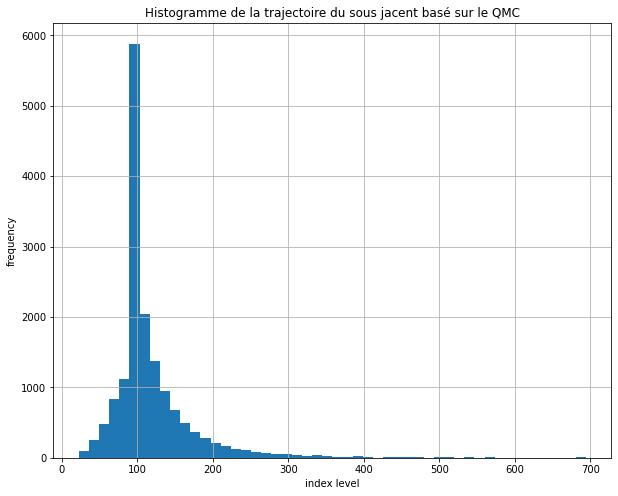

In [17]:
plt.hist(S_t[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.title('Histogramme de la trajectoire du sous jacent basé sur le QMC')

No handles with labels found to put in legend.


<Figure size 720x576 with 0 Axes>

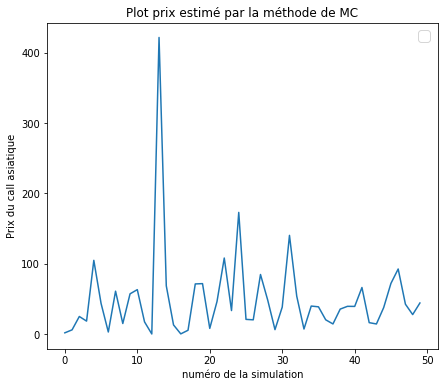

In [83]:

plt.clf()
plt.figure(figsize=(7,6))
plt.plot(C[-1])
plt.title('Plot prix estimé par la méthode de MC')
plt.xlabel('numéro de la simulation')
plt.ylabel('Prix du call asiatique')
plt.legend(fontsize=15)
plt.show()

No handles with labels found to put in legend.


<Figure size 720x576 with 0 Axes>

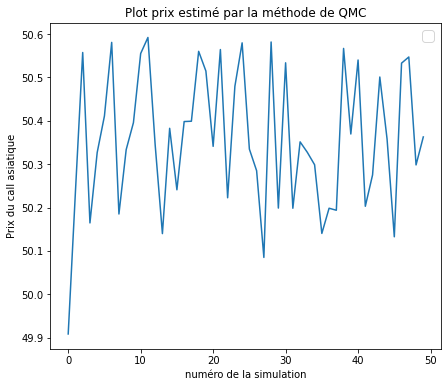

In [82]:
C_0_qmc=np.array(C_0_qmc)
plt.clf()
plt.figure(figsize=(7,6))
plt.plot(C_0_qmc)
plt.title('Plot prix estimé par la méthode de QMC')
plt.xlabel('numéro de la simulation')
plt.ylabel('Prix du call asiatique')
plt.legend(fontsize=15)
plt.show()

In [87]:
#calcul des variances des differentes méthodes
print('variance par la méthode MC standard =',np.var(C[5]))
print('variance par la méthode QMC =',np.var(C_0_qmc))



variance par la méthode MC standard = 4119.76398237209
variance par la méthode QMC = 0.025888899451647296


**COnclusion** 

on constate donc la méthode de Quasi Monté Carlo réduit drastiquement la variance par rapport à la méthode de Méthode de MC 